In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('notes')
import beam.calc.electron as ecalc
from lens import profile
from scipy.optimize import minimize
import scipy.constants as const
me = const.physical_constants['electron mass energy equivalent in MeV'][0]

B matched: 0.00475306789533


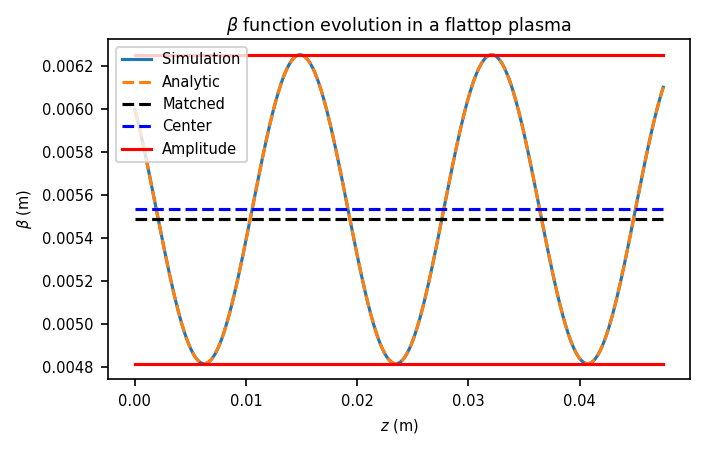

In [2]:
N = 1000
gb0 = 20000
ne0 = 0.5
kp = 5.95074e4 * np.sqrt(ne0)
kb = kp/np.sqrt(2*gb0)
print('B matched:', 1/kb)

# Numerical calculation
beta0 =6e-3
a0 = 0.1
eta = 0.75
z = np.linspace(0, 10/kb, N)
ne = np.ones(N)*ne0*eta
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, a0, gb0, 0, ne0)

# Analytic calculation
B0 = kb*beta0
s = kb*z
theta = 2*np.sqrt(eta)*s
betaA = np.real((B0/2-(a0**2+1)/eta/B0/2+1j*a0/np.sqrt(eta))*np.exp(1j*theta) + (B0/2+(a0**2+1)/eta/B0/2))

Bmatched = 1/kb/np.sqrt(eta)
center = (B0/2+(a0**2+1)/eta/B0/2)/kb
A = 0.5*np.sqrt(B0**2+(a0**2+1)**2/eta**2/B0**2+2*(a0**2-1)/eta)/kb
plt.figure(figsize=(5,3), dpi=150)
plt.plot(z, beta, z, betaA/kb, '--')
plt.plot([0.0, 10/kb], [Bmatched, Bmatched], 'k--')
plt.plot([0.0, 10/kb], [center, center], 'b--')
plt.plot([0.0, 10/kb], [center+A, center+A], 'r-')
plt.plot([0.0, 10/kb], [center-A, center-A], 'r-')
plt.title(r'$\beta$ function evolution in a flattop plasma')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (m)')
plt.legend(['Simulation', 'Analytic', 'Matched', 'Center', 'Amplitude'])
plt.show()

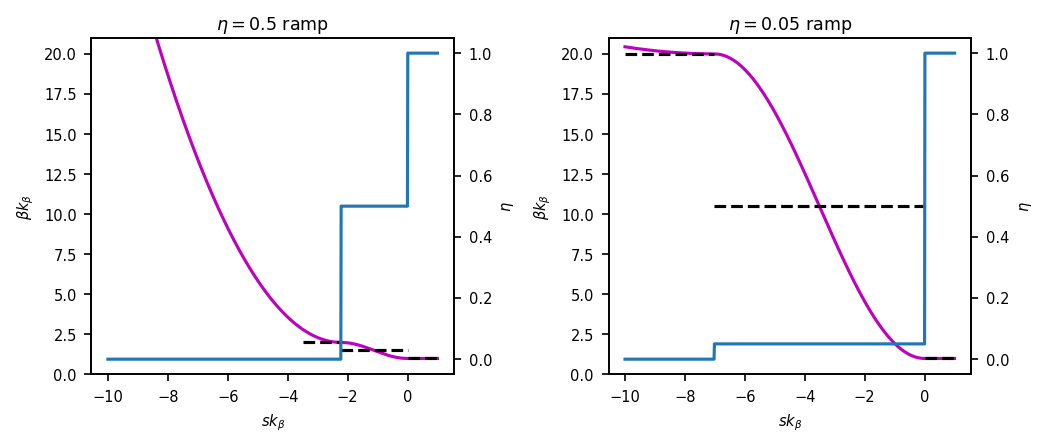

In [3]:
# Lets plot some example square ramps
theta = lambda s: 2*np.sqrt(eta)*s
betaA = lambda s: np.real((B0/2-(a0**2+1)/eta/B0/2+1j*a0/np.sqrt(eta))*np.exp(1j*theta(s))
                          + (B0/2+(a0**2+1)/eta/B0/2))
betaD = lambda s: B0+s**2/B0

N = 1000
B0 = 2
a0 = 0
eta = 0.5
L = np.pi/(2*np.sqrt(eta))
s = np.linspace(-10, 1, N)
sel = [s < -L, (s >= -L) & (s < 0), s >= 0]
ne = np.piecewise(s, sel, [0, eta, 1.0])
beta = np.zeros(N)
beta[sel[0]] = betaD(s[sel[0]]+L)
beta[sel[1]] = betaA(s[sel[1]]+L)
beta[sel[2]] = 1.0
center = (B0/2+(a0**2+1)/eta/B0/2)

plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2)

plt.subplot(gs[0, 0])
plt.plot(s, beta, 'm')
plt.plot([-3.5, -L], [B0, B0], 'k--')
plt.plot([-L, 0.0], [center, center], 'k--')
plt.plot([0.0, 1.0], [1.0, 1.0], 'k--')
plt.title(r'$\eta=0.5$ ramp')
plt.xlabel(r'$s k_\beta$')
plt.ylabel(r'$\beta k_\beta$')
plt.ylim(0.0, 21)
plt.twinx()
plt.plot(s, ne)
plt.ylabel(r'$\eta$')

N = 1000
B0 = 20
a0 = 0
eta = 0.05
L = np.pi/(2*np.sqrt(eta))
s = np.linspace(-10, 1, N)
sel = [s < -L, (s >= -L) & (s < 0), s >= 0]
ne = np.piecewise(s, sel, [0, eta, 1.0])
beta = np.zeros(N)
beta[sel[0]] = betaD(s[sel[0]]+L)
beta[sel[1]] = betaA(s[sel[1]]+L)
beta[sel[2]] = 1.0
center = (B0/2+(a0**2+1)/eta/B0/2)

plt.subplot(gs[0, 1])
plt.plot(s, beta, 'm')
plt.plot([-10, -L], [B0, B0], 'k--')
plt.plot([-L, 0.0], [center, center], 'k--')
plt.plot([0.0, 1.0], [1.0, 1.0], 'k--')
plt.title(r'$\eta=0.05$ ramp')
plt.xlabel(r'$s k_\beta$')
plt.ylabel(r'$\beta k_\beta$')
plt.ylim(0.0, 21)
plt.twinx()
plt.plot(s, ne)
plt.ylabel(r'$\eta$')
plt.tight_layout()
plt.show()

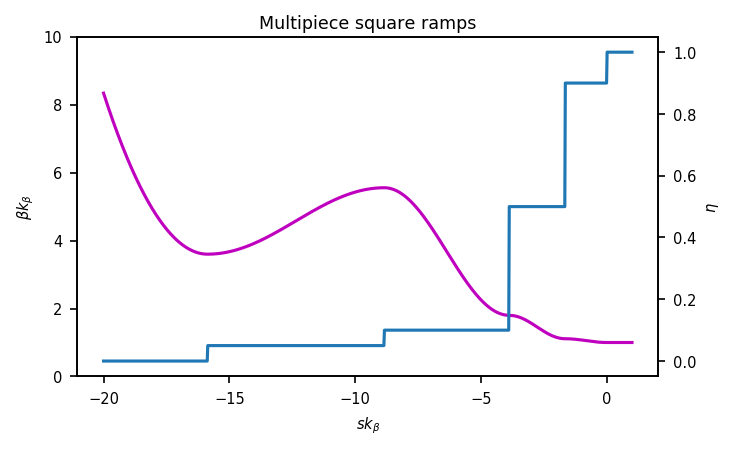

In [4]:
# Lets create the many piece box ramp
def createRamp(etaA, sm, ym):
    theta = lambda s: 2*np.sqrt(eta)*s
    betaA = lambda s: np.real((B0/2-(a0**2+1)/eta/B0/2+1j*a0/np.sqrt(eta))*np.exp(1j*theta(s))
                          + (B0/2+(a0**2+1)/eta/B0/2))
    betaD = lambda s: B0+s**2/B0
    N = 1000
    a0 = 0
    M = len(etaA)
    Li = np.pi/(2*np.sqrt(etaA))
    L = np.zeros(M+2)
    L[1:-1] = np.cumsum(Li)
    L[-1] = sm
    np.append(L, sm)
    s = np.linspace(-sm, 1, N)
    sel = np.zeros((M+2, N), dtype='bool')
    for i in range(0, M+1):
        sel[i] = (s >= -L[M-i+1]) & (s < -L[M-i])
    sel[-1] = s >= 0.0
    etaPW = np.zeros(M+2)
    etaPW[1:-1] = np.flip(etaA, 0)
    etaPW[-1] = 1.0
    ne = np.piecewise(s, sel, etaPW)
    # The tricky bit, calculating the evolution of the beta function
    beta = np.zeros(N)
    beta[sel[-1]] = 1.0
    B0 = 1
    for i in range(M):
        eta = etaA[i]
        beta[sel[-i-2]] = betaA(s[sel[-i-2]]+L[i])
        B0 = beta[sel[-i-2]][0]
    beta[sel[0]] = betaD(s[sel[0]]+L[-2])
    plt.figure(figsize=(5, 3), dpi=150)
    plt.plot(s, beta, 'm')
    plt.title(r'Multipiece square ramps')
    plt.xlabel(r'$s k_\beta$')
    plt.ylabel(r'$\beta k_\beta$')
    plt.ylim(0.0, ym)
    plt.twinx()
    plt.plot(s, ne)
    plt.ylabel(r'$\eta$')
    plt.show()

etaA = np.array([0.9, 0.5, 0.1, 0.05])
sm = 20
createRamp(etaA, sm, 10)

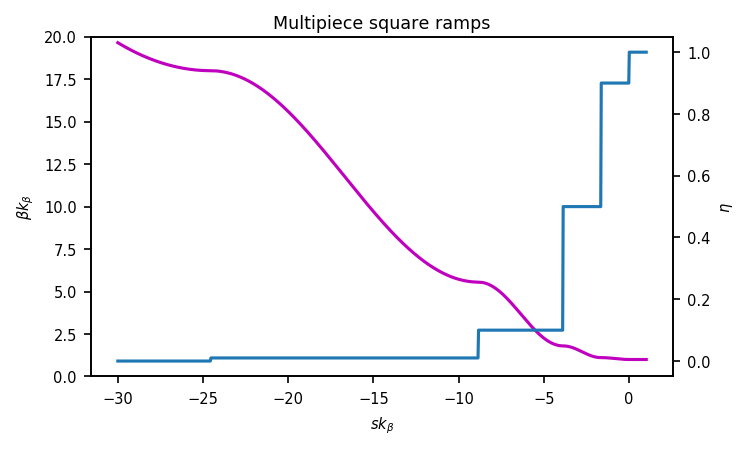

In [5]:
etaA = np.array([0.9, 0.5, 0.1, 0.01])
sm = 30
createRamp(etaA, sm, 20)